In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [5]:
len(cifar10)

50000

In [6]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

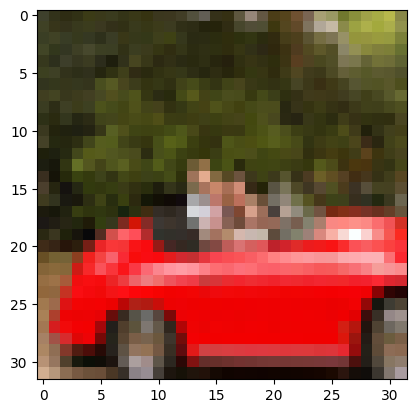

In [7]:
plt.imshow(img)
plt.show()

In [8]:
from torchvision import transforms
#Import all of the possible transforms, including the transform which converts the image to a tensor

In [9]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape #3 channels, 32x32 pixels

torch.Size([3, 32, 32])

In [10]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [11]:
img_t, _ = tensor_cifar10[99]
type(img_t), img_t.min(), img_t.max()

(torch.Tensor, tensor(0.), tensor(1.))

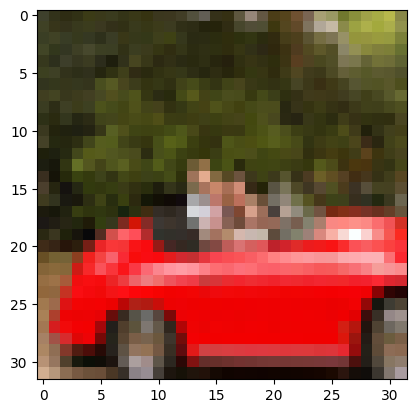

In [12]:
plt.imshow(img_t.permute(1, 2, 0)) #permute so that the colour channels are given by the final index
plt.show()

<p>Recall that, for functions such as the sigmoid, with nonzero gradients for arguments close to 0, it is in our interest to normalise our data so that it is centred at 1. This will increase the speed with which the network is trained on the data. We start by creating a stack in torch using all of the images in the dataset.</p>

In [13]:
imgs = torch.stack([img for img, _ in tensor_cifar10], dim = 3) #Stack along a new dimension
imgs.shape #3x32x32ximg_no

torch.Size([3, 32, 32, 50000])

In [14]:
#Calculate the mean values of the RGB channels
imgs.view(3, -1).mean(dim=1) #tells python that we want a 3*X tensor, where X will be found by python

tensor([0.4914, 0.4822, 0.4465])

In [15]:
#Calculate standard deviation
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [16]:
transforms.Normalize(imgs.view(3,-1).mean(dim=1), imgs.view(3,-1).std(dim=1))

Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))

In [17]:
#Apply transformation, where we now centre all of the colour channels on 0 with unit standard deviation
transformed_cifar10 = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(imgs.view(3,-1).mean(dim=1), imgs.view(3,-1).std(dim=1))])
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802377..2.1267893].


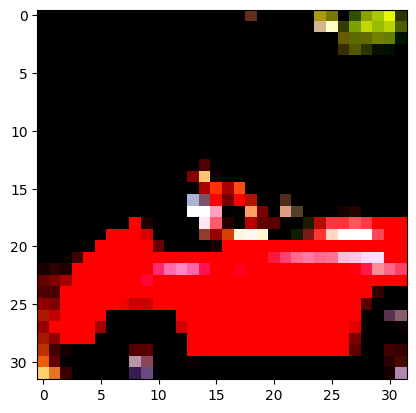

In [18]:
img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show() #Note that all negative RGB values will just be clipped and shown as black

In [19]:
class_names #airplane has index 0, bird has index 2

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
label_map = {0:0, 2:1} #Maps airplane (index 0) to 0, and bird (index 2) to 1
class_names = ['airplane', 'bird']
#2 categories now- airplane and bird
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]] #training set
cifar2_val = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]] #validation set


# Building the Neural Network #
We know that each sample (i.e. each image) is going to have $3\times32\times32 =  3072$ inputs. So the first layer will be linear, with a first dimension of $3072$. We chose $512$ dimensions for our hidden layer, and our activation function will be tanh.


In [21]:
import torch.nn as nn

In [22]:
n_out = 2 #Number of output features- either a BIRD, or a PLANE
#Categorical data, so cannot output a single floating-point value on a scale of bird to plane, as the distinction is binary

#Constructing the neural network with the appropriate number of dimensions
model = nn.Sequential(
    nn.Linear(3072, 512), #Linear hidden layer taking the input data
    nn.Tanh(), #Hidden layer activation function
    nn.Linear(512, 2) #Output layer
)

# Softmax Function
The softmax function is given by: $$\frac{e^}{}$$